In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [20]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [22]:
def create_filtered_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
    return syntethic_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [23]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [37]:
display(Markdown(filtered_fitness_df.iloc[:, [4] + list(range(18, 20)) + [21, 22, 23]].groupby('real').mean(numeric_only=True).to_markdown()))

|   real |   pref_forall_correct_arity |   pref_forall_correct_types |   no_two_number_operations |   section_without_pref_count_terminal |   section_without_pref_count_scoring |
|-------:|----------------------------:|----------------------------:|---------------------------:|--------------------------------------:|-------------------------------------:|
|      0 |                    0.976299 |                    0.973262 |                   0.985209 |                              0.540816 |                                    0 |
|      1 |                    1        |                    1        |                   1        |                              0.540816 |                                    0 |

In [51]:
[c for c in filtered_fitness_df.columns if 'compositionality' in c]

['compositionality_structure_0',
 'compositionality_structure_1',
 'compositionality_structure_2',
 'compositionality_structure_3',
 'compositionality_structure_4',
 'compositionality_structure_5',
 'compositionality_structure_6',
 'compositionality_structure_7',
 'compositionality_structure_8',
 'compositionality_structure_9',
 'compositionality_structure_10',
 'compositionality_structure_11',
 'compositionality_structure_12']

In [53]:
for p in fitness_features.COMPOSITIONALITY_STRUCTURES:
    print(p)

(hold (and (not (agent_holds ?x) ) (in_motion ?x) ) )
(once (and (not (in_motion ?x) ) (in ?x ?x) ) )
(once (agent_holds ?x) )
(once (not (in_motion ?x) ) )
(once (and (agent_holds ?x) (adjacent ?x ?x) ) )
(hold-while (and (not (agent_holds ?x) ) (in_motion ?x) ) (touch ?x ?x) )
(once (and (not (in_motion ?x) ) (on ?x ?x) ) )
(hold-while (and (in_motion ?x) (not (agent_holds ?x) ) ) (touch ?x ?x) )
(once (and (adjacent ?x ?x) (agent_holds ?x) ) )
(hold-while (and (not (agent_holds ?x) ) (in ?x ?x) (or (agent_holds ?x) (and (not (agent_holds ?x) ) (in_motion ?x) ) ) ) (touch ?x ?x) )
(hold-while (and (in_motion ?x) (not (agent_holds ?x) ) ) (touch ?x ?x) (in_motion ?x) )
(hold-while (and (not (agent_holds ?x) ) (in_motion ?x) ) (on ?x ?x) )
(once (and (agent_holds ?x) (on ?x ?x) ) )


In [ ]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In [ ]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

In [ ]:
sum(never_change)

In [ ]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



In [54]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    feature_columns=all_feature_columns, scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
{'ecdf': -0.3010384615384615, 'game_rank': 0.874218761920929}


### Test results:

{'ecdf': -0.3010384615384615, 'game_rank': 0.874218761920929}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
19,2,4,<function fitness_hinge_loss at 0x15c51a9e0>,0.03,1,835,2.0,-0.276983,0.012538,1,0.880807,0.012144,109
106,2,8,<function fitness_hinge_loss at 0x15c51a9e0>,0.01,4,835,1.0,-0.282196,0.022852,2,0.879727,0.025007,144
527,4,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,8,835,2.0,-0.282571,0.032158,3,0.881328,0.019931,103
650,8,4,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,4,835,1.0,-0.283602,0.036020,4,0.881484,0.020826,98
838,8,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,2,835,1.0,-0.284828,0.025365,5,0.880221,0.024720,132
519,4,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,2,835,2.0,-0.285821,0.027498,6,0.882135,0.023763,84
839,8,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,2,835,2.0,-0.285896,0.012689,7,0.881914,0.017704,88
26,2,4,<function fitness_hinge_loss at 0x15c51a9e0>,0.03,4,835,1.0,-0.286745,0.017587,8,0.881523,0.023170,95
842,8,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,4,835,1.0,-0.286751,0.025233,9,0.876576,0.024346,278
75,2,8,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,4,835,2.0,-0.288116,0.022722,10,0.877174,0.017626,247


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
268,2,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,8,835,0.00,-0.303727,0.033224,359,0.892656,0.013248,1
588,4,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,8,835,0.00,-0.302702,0.028617,303,0.892435,0.016341,2
280,2,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.03,4,835,0.00,-0.298134,0.025093,124,0.890833,0.015497,3
264,2,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,4,835,0.00,-0.305464,0.034569,469,0.890807,0.012173,4
580,4,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,2,835,0.00,-0.301992,0.026416,270,0.890560,0.013841,5
832,8,32,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,1,835,0.00,-0.302111,0.022203,278,0.890091,0.018709,6
1224,16,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,4,835,0.00,-0.298082,0.019144,120,0.890091,0.018136,6
284,2,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.03,8,835,0.00,-0.298126,0.024399,123,0.889375,0.013696,8
1228,16,64,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,8,835,0.00,-0.296663,0.020289,78,0.889232,0.016491,9
321,4,4,<function fitness_hinge_loss at 0x15c51a9e0>,0.10,1,835,0.25,-0.319000,0.023015,1019,0.889167,0.015954,10


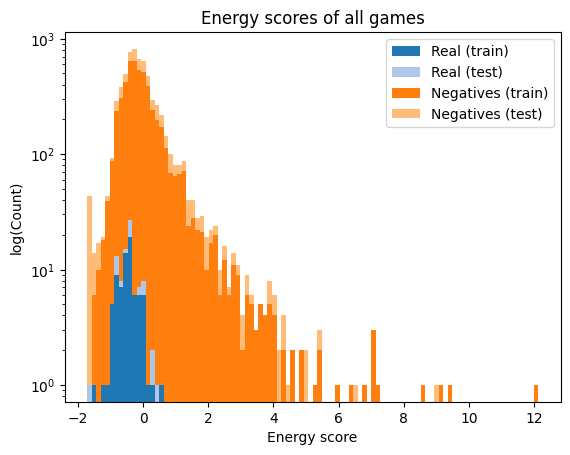

0.002085714 0.020068612 4.6121598e-10


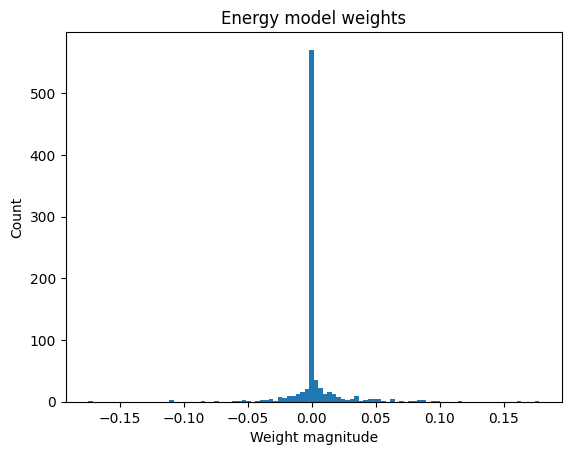

In [55]:
utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)  #, histogram_title_note='with `real` flag')

In [56]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [59]:
cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2023_01_19.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# DEFAULT_FITNESS_FUNCTION_PATH = '../models/cv_fitness_model_2022_12_23.pkl.gz'
# with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
#     cv_fitness_model = pickle.load(f)

cv_fitness_model = cv.best_estimator_

In [ ]:
cv.best_estimator_.fit(train_tensor)

In [ ]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()  # type: ignore
feature_columns = [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
n_top = 10
sorted_indices = np.argsort(weights)
top_weight_indices = sorted_indices[-n_top:]
bottom_weight_indices = sorted_indices[:n_top]

top_features = [feature_columns[i] for i in top_weight_indices][::-1]
bottom_features = [feature_columns[i] for i in bottom_weight_indices]

print('Features with strongest negative weights')
for i, f in enumerate(bottom_features):
    print(f'{i+1}. {f} ({weights[bottom_weight_indices[i]]:.3f})')

print('Features with strongest positive weights')
for i, f in enumerate(top_features):
    print(f'{i+1}. {f} ({weights[top_weight_indices[i]]:.3f})')



In [ ]:
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze()  # type: ignore
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze()  # type: ignore
score_diffs = train_positive_scores.unsqueeze(-1) - train_negative_scores
torch.topk(score_diffs.ravel(), k=20, largest=True)

In [ ]:
utils.evaluate_energy_contributions(cv, train_tensor, 3621, feature_columns, full_tensor, real_game_texts, regrown_game_texts, top_k=5)

## Alternative experiments

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_softmin_hybrid_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)


utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)

## Trying the old hinge loss, but with no negative averaging

In [ ]:
test_param_grid = [
    # {
    #     'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
    #     'fitness__weight_decay': [0.0, 0.25, 1, 2],  
    #     'fitness__margin': [1, 2, 4, 8],
    #     # 'fitness__beta': [0.25, 1, 2, 4],
    #     'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
    #     'fitness__k': [4, 8, 16, 32, 64],
    #     'fitness__batch_size': [4, 8, 16, 32],  # [1, 4, 8, 16],
    #     # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    # },
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, ],  
        'fitness__margin': [1, 2,],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2,],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [32, 64],
        'fitness__batch_size': [8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)